In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
from windrose import WindroseAxes

import statsmodels.graphics.tsaplots
import statsmodels.tsa.stattools
%matplotlib inline

In [2]:
# Read data
desc = pd.read_csv('../datasets/original/data_description.csv', sep=';')
data1_pd = pd.read_csv('../datasets/original/la-haute-borne-data-2013-2016.csv', sep=';')
data2_pd = pd.read_csv('../datasets/original/la-haute-borne-data-2017-2020.csv', sep=';')

In [3]:
desc

,Variable_name,Variable_long_name,Unit_long_name,Comment
0,Q,Reactive_power,kVAr,NaN
1,Ws,Wind_speed,m/s,Average wind speed
2,Va2,Vane_position_2,deg,Second wind vane on the nacelle
3,Git,Gearbox_inlet_temperature,deg_C,NaN
4,Ot,Outdoor_temperature,deg_C,NaN
5,Ws2,Wind_speed_2,m/s,Second anemometer on the nacelle
6,Nf,Grid_frequency,Hz,NaN
7,Nu,Grid_voltage,V,NaN
8,Dst,Generator_stator_temperature,deg_C,NaN
9,Wa_c,Absolute_wind_direction_corrected,deg,NaN


In [4]:
COLNAMES = {
    'Ws_avg': 'Wind speed',
    'P_avg': 'Power', 
    'Ot_avg': 'Temperature',
    'Ya_avg': 'Nacelle angle',
    'Ba_avg': 'Pitch angle', 
    'Wa_avg': 'Wind direction'
}

In [5]:
# Join datasets
data_pd = pd.concat([data1_pd, data2_pd], axis=0)

print(data1_pd.shape)
print(data2_pd.shape)
print(data_pd.shape)

(840380, 138)
(217588, 138)
(1057968, 138)


In [6]:
# Leave only columns of interest
data_pd = data_pd[
    ["Date_time", "Wind_turbine_name"]+list(COLNAMES.keys())]

In [7]:
# Resample to 1H resolution
data_pd = data_pd.groupby('Wind_turbine_name').apply(
    lambda d: d.set_index(
        pd.DatetimeIndex(
            pd.to_datetime(
                d['Date_time'], format="%Y-%m-%dT%H:%M:%S", utc=True
            )
        ), drop=True
    ) 
                .resample("1H").mean()
)

# Reset index
data_pd = data_pd.reset_index()

In [8]:
print(data_pd.shape)

(176452, 8)


In [9]:
np.array(data_pd.columns)

array(['Wind_turbine_name', 'Date_time', 'Ws_avg', 'P_avg', 'Ot_avg',
       'Ya_avg', 'Ba_avg', 'Wa_avg'], dtype=object)

In [10]:
# Add weather data
weather_pd = pd.read_csv('../datasets/weather_data/weather_parameters.csv', encoding='utf-8')
weather_pd['Date_time'] = pd.to_datetime(weather_pd['date_time'], utc=True, errors='coerce')
print(weather_pd.columns)

# Prepare for merge
COLNAMES = ['date_time', 'humidity', 'pressure', 'precipMM']
weather_pd = weather_pd[COLNAMES]
weather_pd = weather_pd.rename(columns={"date_time": "Date_time"})
weather_pd['Date_time'] = pd.to_datetime(weather_pd["Date_time"], format="%Y-%m-%dT%H:%M:%S", utc=True)
weather_pd = weather_pd.set_index('Date_time', drop=True)

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'Date_time'],
      dtype='object')


In [11]:
# Join dataframes
data_pd = pd.merge(data_pd, weather_pd, on='Date_time', how='left')

In [12]:
# Rename columns
COLNAMES = {
    'Ws_avg': 'Wind speed',
    'P_avg': 'Power', 
    'Ot_avg': 'Temperature',
    'Ya_avg': 'Nacelle angle',
    'Ba_avg': 'Pitch angle', 
    'Wa_avg': 'Wind direction',
    'humidity': 'Humidity',
    'pressure': 'Pressure',
    'precipMM': 'Precipitation'
}

data_pd = data_pd.rename(columns=COLNAMES)

# How many nans?

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


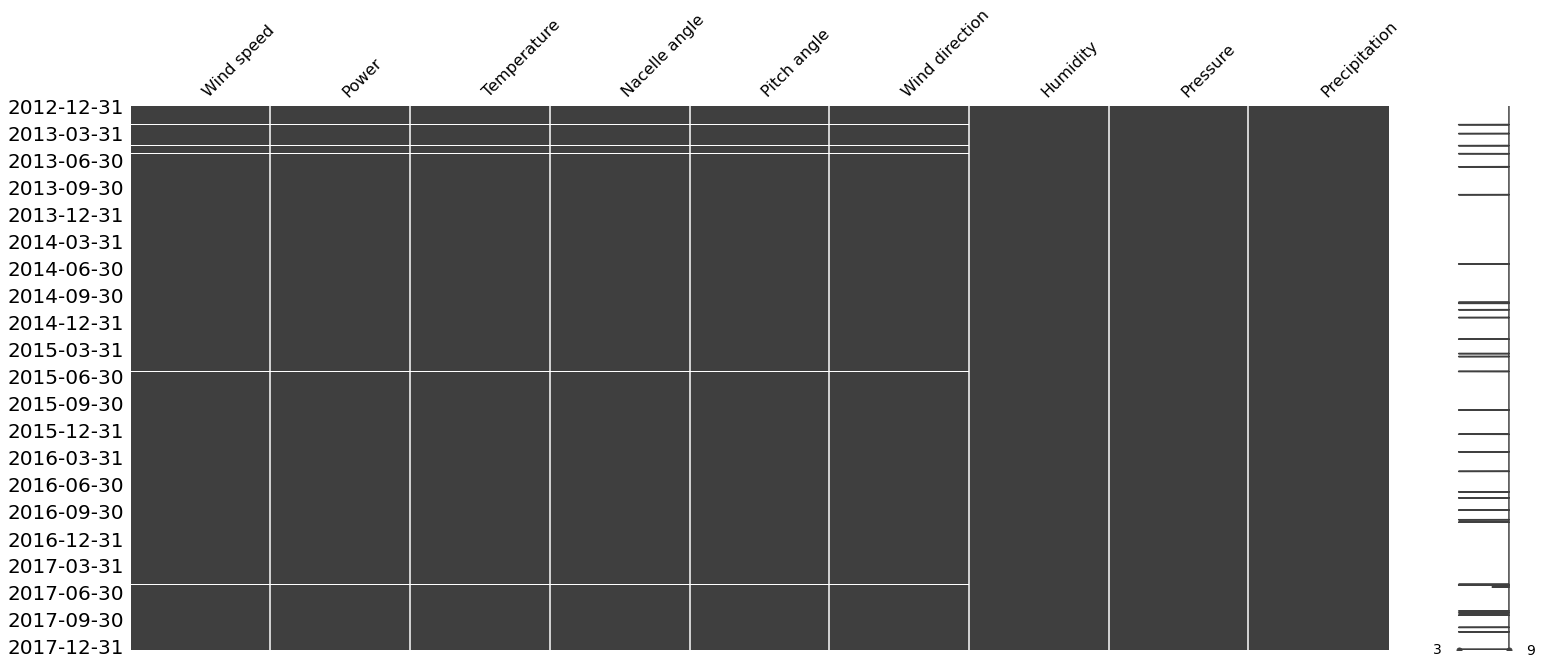

In [13]:
msno.matrix(data_pd[data_pd['Wind_turbine_name']=='R80711'].drop(['Wind_turbine_name'], axis=1).set_index("Date_time", drop=True),  freq='Q')
plt.tight_layout()
plt.savefig("missing_data.pdf", dpi=600, facecolor='white', transparent=False)

In [14]:
data_pd.isnull().sum(axis = 0)

Wind_turbine_name       0
Date_time               0
Wind speed           1084
Power                1084
Temperature          1130
Nacelle angle        1084
Pitch angle          1130
Wind direction       1084
Humidity                0
Pressure                0
Precipitation           0
dtype: int64

In [15]:
# Remove nans
data_pd = data_pd.dropna()

<Figure size 432x288 with 0 Axes>

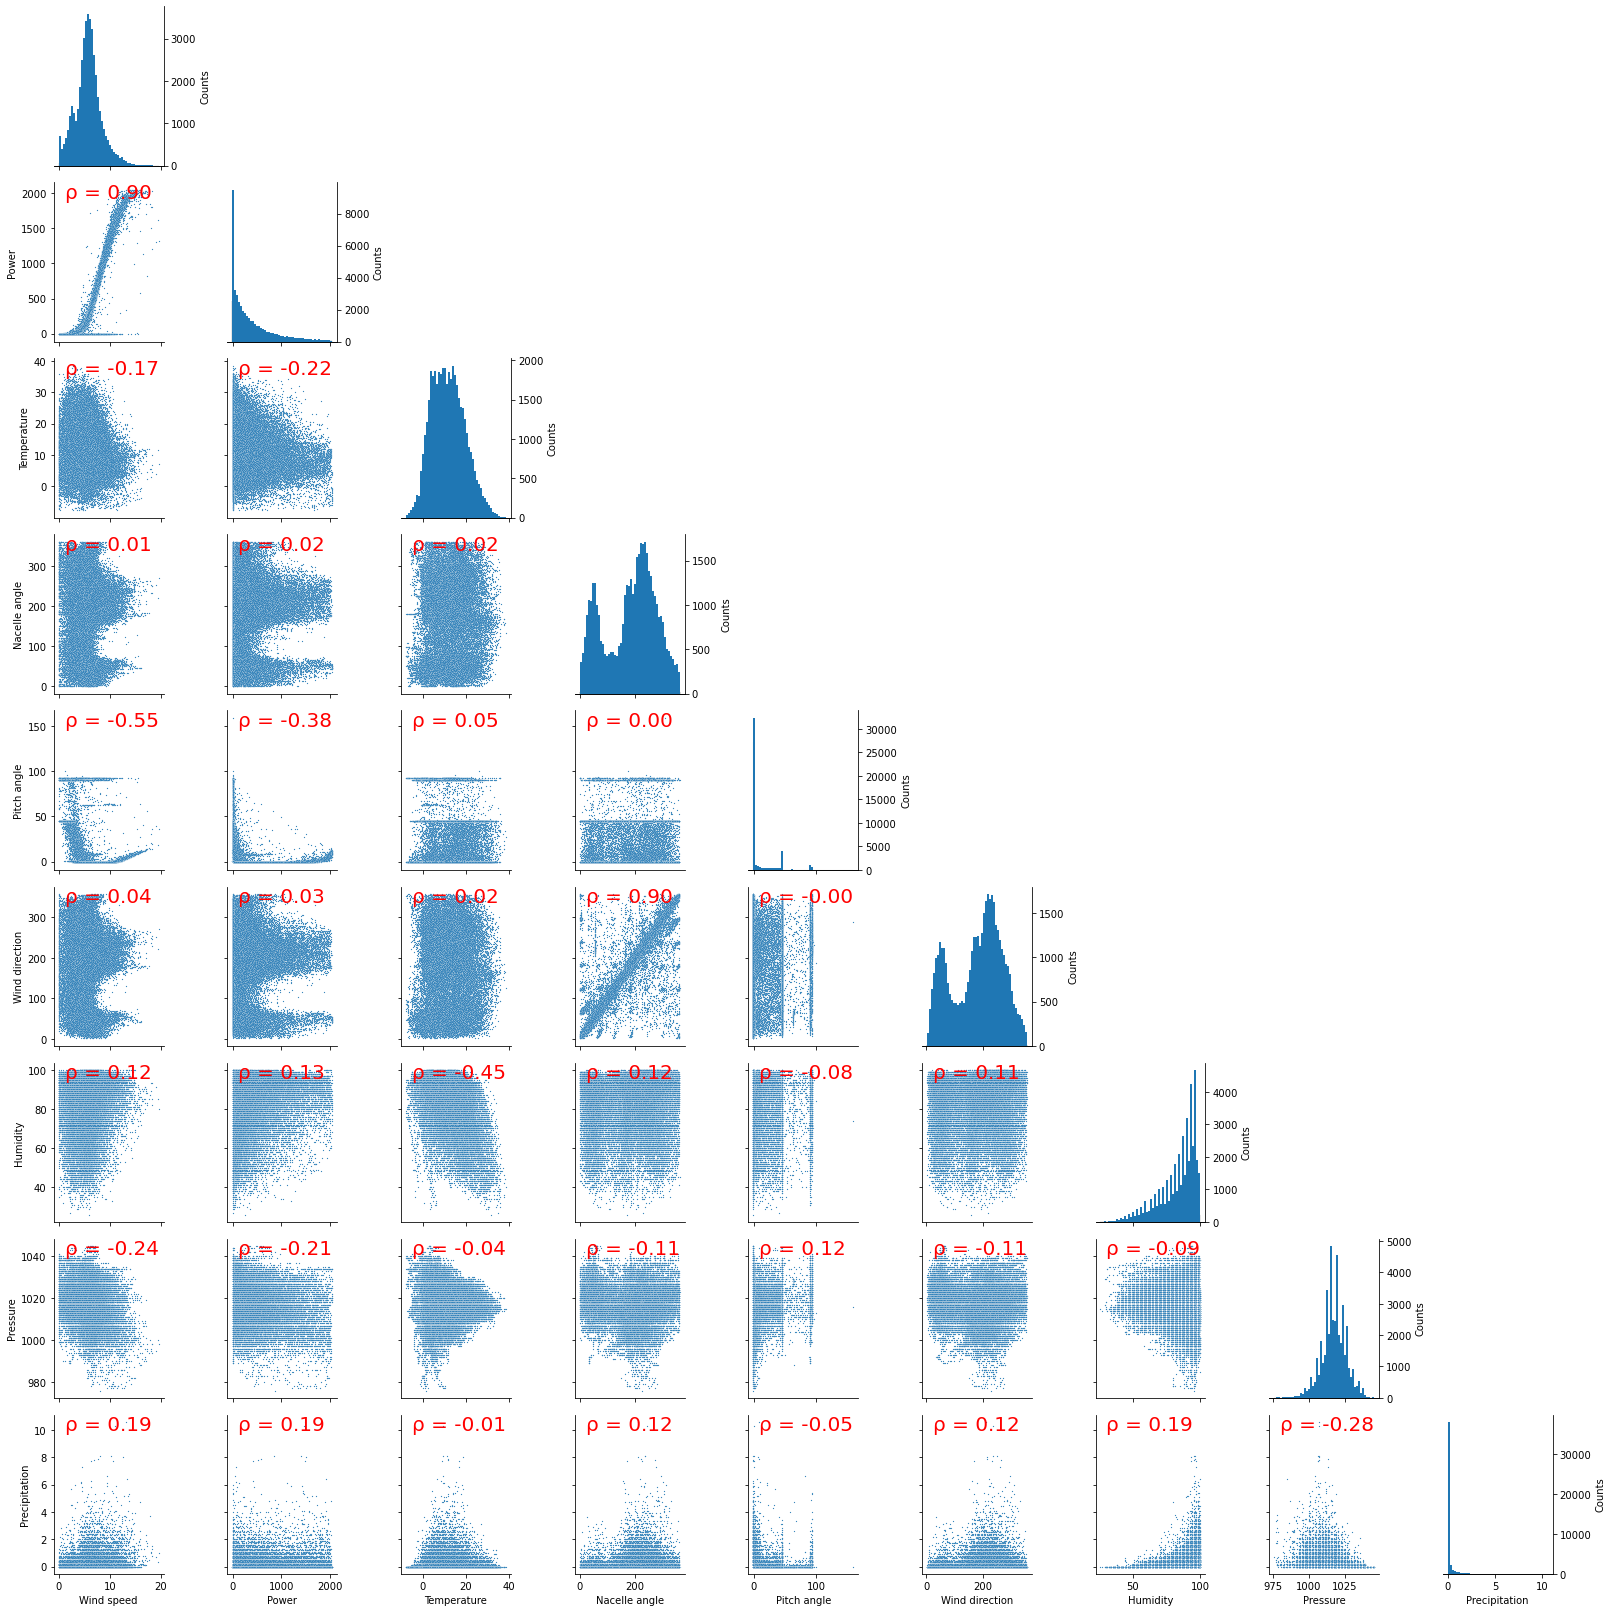

In [16]:
from scipy.stats import pearsonr

def my_hist(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sns.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    ax.hist(x, label=label, color=color, bins=50)

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, color='red', fontsize=20)

plt.figure()
g = sns.pairplot(data_pd[data_pd['Wind_turbine_name']=="R80711"].drop(
    ['Wind_turbine_name', 'Date_time'], axis=1),
                plot_kws={'s':1.5},
                corner=True)
g.map_lower(corrfunc)
g.map_diag(my_hist)
plt.tight_layout()
plt.savefig("cornerplot.png", dpi=450, facecolor='white', transparent=False)

Text(0, 0.5, 'Count')

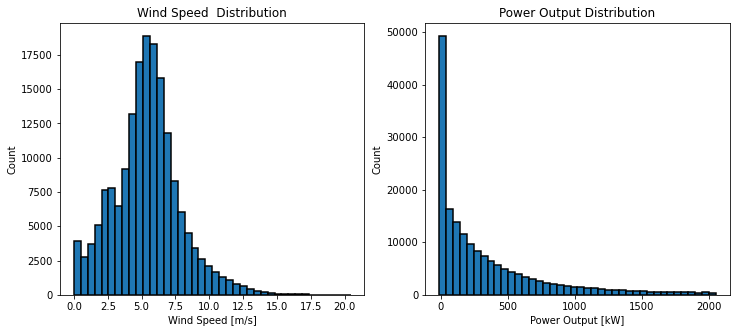

In [17]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(data_pd['Wind speed'],bins = 40, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Wind Speed  Distribution')
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Count')
ax2.hist(data_pd['Power'],bins = 40, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Power Output Distribution')
ax2.set_xlabel('Power Output [kW]')
ax2.set_ylabel('Count')

In [18]:
# Check for average and median wind speed
print(data_pd[data_pd['Wind_turbine_name'] == 'R80711']['Wind speed'].mean())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80711']['Wind speed'].median())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80721']['Wind speed'].mean())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80721']['Wind speed'].median())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80736']['Wind speed'].mean())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80736']['Wind speed'].median())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80790']['Wind speed'].mean())
print(data_pd[data_pd['Wind_turbine_name'] == 'R80790']['Wind speed'].median())

5.7012822082400305
5.685000033333334
5.215993461341935
5.293333283333333
5.283870385939437
5.314999983333333
5.427826463697071
5.363333316666666


In [19]:
data_pd['Wind_turbine_name'].unique()

array(['R80711', 'R80721', 'R80736', 'R80790'], dtype=object)

# Check for stationarity

Based on this article: https://machinelearningmastery.com/time-series-data-stationary-python/

In [20]:
# USE Augmented Dickey-Fuller test
# based on: https://machinelearningmastery.com/time-series-data-stationary-python/

def calc_adf(ts):
    result = statsmodels.tsa.stattools.adfuller(
        ts, 
        autolag='AIC')
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

calc_adf(data_pd[data_pd['Wind_turbine_name']=='R80711']['Power'].values)
calc_adf(data_pd[data_pd['Wind_turbine_name']=='R80721']['Power'].values)
calc_adf(data_pd[data_pd['Wind_turbine_name']=='R80736']['Power'].values)
calc_adf(data_pd[data_pd['Wind_turbine_name']=='R80790']['Power'].values)

ADF Statistic: -18.807746
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -18.974472
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -21.663946
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -17.505229
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [21]:
def calc_kpss(ts):
    result = statsmodels.tsa.stattools.kpss(ts)

    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

calc_kpss(data_pd[data_pd['Wind_turbine_name']=='R80711']['Power'].values)
calc_kpss(data_pd[data_pd['Wind_turbine_name']=='R80721']['Power'].values)
calc_kpss(data_pd[data_pd['Wind_turbine_name']=='R80736']['Power'].values)
calc_kpss(data_pd[data_pd['Wind_turbine_name']=='R80790']['Power'].values)

KPSS Statistic: 0.228428
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Statistic: 0.195623
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Statistic: 0.210474
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Statistic: 3.901320
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test stat

# Check for not normal working conditions


* Power Output (kW): it must be above 0 kW and below the maximum rated power (in this example 2050kW)
* Wind Speed (m/s): it must be above 0 m/s
* Large pitch angle

In [22]:
data_pd.columns

Index(['Wind_turbine_name', 'Date_time', 'Wind speed', 'Power', 'Temperature',
       'Nacelle angle', 'Pitch angle', 'Wind direction', 'Humidity',
       'Pressure', 'Precipitation'],
      dtype='object')

In [23]:
# How many observations have power output = 0?
print("---------------- ------------------------")
print("# Total samples: \t\t\t {}".format(len(np.array(data_pd['Power']))))
print("# Samples with power output = 0: \t {}".format(len(np.where(np.array(data_pd['Power']).round(3) < 0.00)[0])))

# How many observations have wind speed = 0?
print("---------------- ------------------------")
print("# Total samples: \t\t\t {}".format(len(np.array(data_pd['Wind speed']))))
print("# Samples with power output = 0: \t {}".format(len(np.where(np.array(data_pd['Wind speed']).round(3) < 0.00)[0])))

# How many observations have large pitch angle?
print("---------------- ------------------------")
print("# Total samples: \t\t\t {}".format(len(np.array(data_pd['Pitch angle']))))
print("# Samples with too small pitch angle: \t {}".format(len(np.where((np.array(data_pd['Pitch angle']).round(3)) < -10.00)[0])))

# How many observations have large pitch angle?
print("---------------- ------------------------")
print("# Total samples: \t\t\t {}".format(len(np.array(data_pd['Pitch angle']))))
print("# Samples with too large pitch angle: \t {}".format(len(np.where((np.array(data_pd['Pitch angle']).round(3)) >= 90.00)[0])))

---------------- ------------------------
# Total samples: 			 175322
# Samples with power output = 0: 	 29546
---------------- ------------------------
# Total samples: 			 175322
# Samples with power output = 0: 	 0
---------------- ------------------------
# Total samples: 			 175322
# Samples with too small pitch angle: 	 4
---------------- ------------------------
# Total samples: 			 175322
# Samples with too large pitch angle: 	 9935


In [45]:
def check_outliers(df):
    # How many observations have power output = 0?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Power']))))
    print("# Samples with power output = 0: \t {}".format(len(np.where(np.array(df['Power']).round(3) == 0.00)[0])))
    print("# Samples with power output < 0: \t {}".format(len(np.where(np.array(df['Power']).round(3) < 0.00)[0])))

    # How many observations have wind speed = 0?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Wind speed']))))
    print("# Samples with wind speed = 0: \t\t {}".format(len(np.where(np.array(df['Wind speed']).round(3) == 0.00)[0])))
    print("# Samples with wind speed < 0: \t\t {}".format(len(np.where(np.array(df['Wind speed']).round(3) < 0.00)[0])))

    # How many observations have large pitch angle?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Pitch angle']))))
    print("# Samples with too small pitch angle: \t {}".format(len(np.where((np.array(df['Pitch angle']).round(3)) < -10.00)[0])))

    # How many observations have large pitch angle?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Pitch angle']))))
    print("# Samples with too large pitch angle: \t {}".format(len(np.where((np.array(df['Pitch angle']).round(3)) >= 90.00)[0])))

print("Turbine: R80711")
check_outliers(data_pd[data_pd['Wind_turbine_name']=='R80711'])
print(" ")
print(" ")
print("Turbine: R80721")
check_outliers(data_pd[data_pd['Wind_turbine_name']=='R80721'])
print(" ")
print(" ")
print("Turbine: R80736")
check_outliers(data_pd[data_pd['Wind_turbine_name']=='R80736'])
print(" ")
print(" ")
print("Turbine: R80790")
check_outliers(data_pd[data_pd['Wind_turbine_name']=='R80790'])

Turbine: R80711
---------------- ------------------------
# Total samples: 			 38195
# Samples with power output = 0: 	 673
# Samples with power output < 0: 	 0
---------------- ------------------------
# Total samples: 			 38195
# Samples with wind speed = 0: 		 15
# Samples with wind speed < 0: 		 0
---------------- ------------------------
# Total samples: 			 38195
# Samples with too small pitch angle: 	 0
---------------- ------------------------
# Total samples: 			 38195
# Samples with too large pitch angle: 	 0
 
 
Turbine: R80721
---------------- ------------------------
# Total samples: 			 37071
# Samples with power output = 0: 	 981
# Samples with power output < 0: 	 0
---------------- ------------------------
# Total samples: 			 37071
# Samples with wind speed = 0: 		 37
# Samples with wind speed < 0: 		 0
---------------- ------------------------
# Total samples: 			 37071
# Samples with too small pitch angle: 	 0
---------------- ------------------------
# Total samples

In [46]:
#data_pd = data_pd[data_pd['Power'] > 0]
data_pd = data_pd[data_pd['Wind speed'] >= 0]
data_pd = data_pd[data_pd['Power'] >= 0]
data_pd = data_pd[data_pd['Pitch angle'] > -10]
data_pd = data_pd[data_pd['Pitch angle'] < 90.0]

# Check for seasonality

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


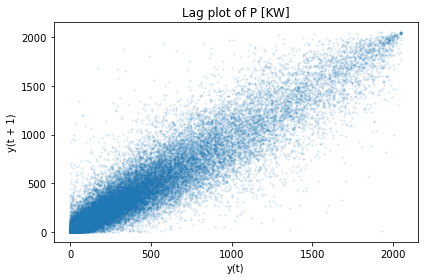

In [47]:
pd.plotting.lag_plot(data_pd[data_pd['Wind_turbine_name']=='R80711']['Power'], alpha=0.1, s=2)
plt.title("Lag plot of P [KW]")
plt.tight_layout()
plt.savefig("lag_plot.png", dpi=800, bbox_inches='tight')
plt.show()

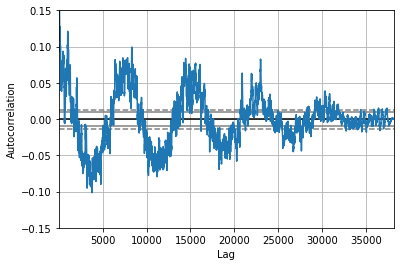

In [48]:
plt.figure()

pd.plotting.autocorrelation_plot(data_pd[data_pd['Wind_turbine_name']=='R80711']['Power']).set_ylim([-0.15, 0.15])
plt.savefig("autocorrelation_plot.pdf", dpi=700)

In [49]:
data_pd[data_pd['Wind_turbine_name']=='R80711']['Power'].autocorr(lag=1)

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9278044117120435

#### POWER OUTPUT CALCULATION

In [20]:
data_pd['Wind_turbine_name'].unique()

array(['R80711', 'R80721', 'R80736', 'R80790'], dtype=object)

In [21]:
data_poutput_1 = data_pd[data_pd['Wind_turbine_name']=='R80711']
data_poutput_1.loc[:, 'E_avg'] = data_poutput_1.loc[:, 'Power'] / 6000 # from kW to MWh
data_poutput_1['Month'] = data_poutput_1['Date_time'].dt.month
data_poutput_1['Year'] = data_poutput_1['Date_time'].dt.year

data_poutput_1 = pd.DataFrame(data_poutput_1.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
data_poutput_1.reset_index(inplace=True)

#data_poutput_1_boxplot = data_poutput_1[data_poutput_1.E_avg > 10]

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 720x504 with 0 Axes>

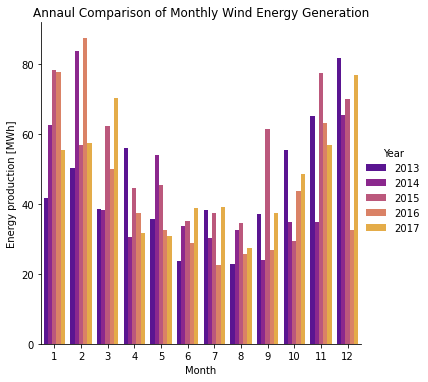

In [53]:
plt.figure(figsize=(10, 7))
sns.catplot(x="Month", y="E_avg", hue="Year",
               data=data_poutput_1[~data_poutput_1['Year'].isin([2012, 2018])], kind="bar", palette="plasma")
plt.title("Annaul Comparison of Monthly Wind Energy Generation")
plt.ylabel('Energy production [MWh]')
plt.savefig("monthly_energy_generation.png", dpi=450, bbox_inches='tight')

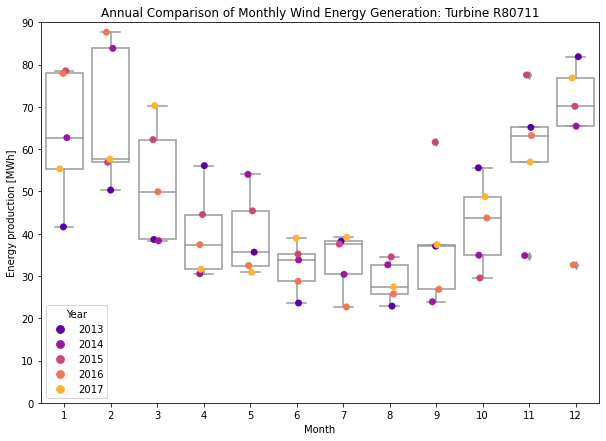

In [23]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=data_poutput_1[~data_poutput_1['Year'].isin([2012, 2018])], x='Month', y='E_avg',color='white')
sns.stripplot(data=data_poutput_1[~data_poutput_1['Year'].isin([2012, 2018])], x='Month', y='E_avg', hue="Year", size=7, palette='plasma')
plt.title('Annual Comparison of Monthly Wind Energy Generation: Turbine R80711')
plt.xlabel('Month')
plt.ylabel('Energy production [MWh]')
plt.ylim([0, 90])
plt.savefig("monthly_energy_generation_R80711.png", dpi=450, bbox_inches='tight')

In [24]:
data_poutput_2 = data_pd[data_pd['Wind_turbine_name']=='R80721']
data_poutput_2.loc[:, 'E_avg'] = data_poutput_2.loc[:, 'Power'] / 6000 # from kW to MWh
data_poutput_2['Month'] = data_poutput_2['Date_time'].dt.month
data_poutput_2['Year'] = data_poutput_2['Date_time'].dt.year

data_poutput_2 = pd.DataFrame(data_poutput_2.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
data_poutput_2.reset_index(inplace=True)


/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 

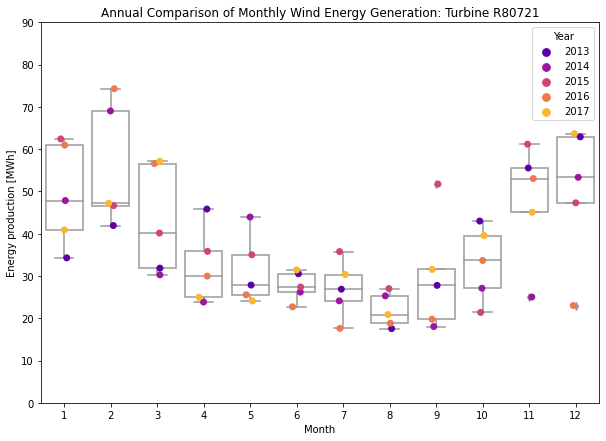

In [25]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=data_poutput_2[~data_poutput_2['Year'].isin([2012, 2018])], x='Month', y='E_avg',color='white')
sns.stripplot(data=data_poutput_2[~data_poutput_2['Year'].isin([2012, 2018])], x='Month', y='E_avg', hue="Year", size=7, palette='plasma')
plt.title('Annual Comparison of Monthly Wind Energy Generation: Turbine R80721')
plt.xlabel('Month')
plt.ylabel('Energy production [MWh]')
plt.ylim([0, 90])
plt.savefig("monthly_energy_generation_R80721.png", dpi=450, bbox_inches='tight')

In [26]:
data_pd['Wind_turbine_name'].unique()

array(['R80711', 'R80721', 'R80736', 'R80790'], dtype=object)

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 

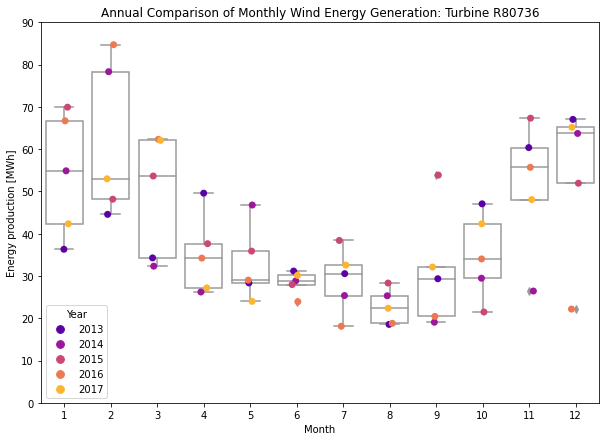

In [27]:
data_poutput_3 = data_pd[data_pd['Wind_turbine_name']=='R80736']
data_poutput_3.loc[:, 'E_avg'] = data_poutput_3.loc[:, 'Power'] / 6000 # from kW to MWh
data_poutput_3['Month'] = data_poutput_3['Date_time'].dt.month
data_poutput_3['Year'] = data_poutput_3['Date_time'].dt.year

data_poutput_3 = pd.DataFrame(data_poutput_3.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
data_poutput_3.reset_index(inplace=True)

plt.figure(figsize=(10, 7))
sns.boxplot(data=data_poutput_3[~data_poutput_3['Year'].isin([2012, 2018])], x='Month', y='E_avg',color='white')
sns.stripplot(data=data_poutput_3[~data_poutput_3['Year'].isin([2012, 2018])], x='Month', y='E_avg', hue="Year", size=7, palette='plasma')
plt.title('Annual Comparison of Monthly Wind Energy Generation: Turbine R80736')
plt.xlabel('Month')
plt.ylabel('Energy production [MWh]')
plt.ylim([0, 90])
plt.savefig("monthly_energy_generation_R80736.png", dpi=450, bbox_inches='tight')

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 

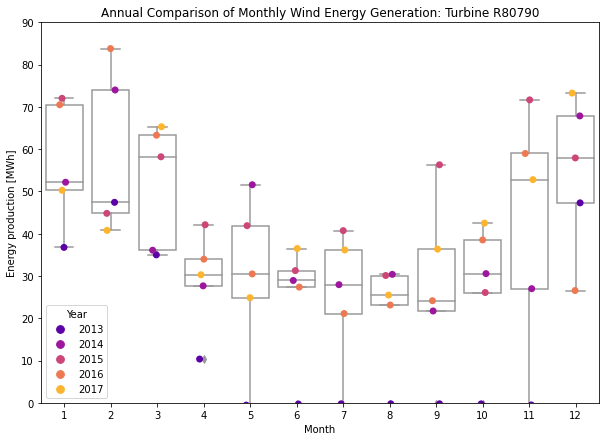

In [28]:
data_poutput_4 = data_pd[data_pd['Wind_turbine_name']=='R80790']
data_poutput_4.loc[:, 'E_avg'] = data_poutput_4.loc[:, 'Power'] / 6000 # from kW to MWh
data_poutput_4['Month'] = data_poutput_4['Date_time'].dt.month
data_poutput_4['Year'] = data_poutput_4['Date_time'].dt.year

data_poutput_4 = pd.DataFrame(data_poutput_4.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
data_poutput_4.reset_index(inplace=True)

plt.figure(figsize=(10, 7))
sns.boxplot(data=data_poutput_4[~data_poutput_4['Year'].isin([2012, 2018])], x='Month', y='E_avg',color='white')
sns.stripplot(data=data_poutput_4[~data_poutput_4['Year'].isin([2012, 2018])], x='Month', y='E_avg', hue="Year", size=7, palette='plasma')
plt.title('Annual Comparison of Monthly Wind Energy Generation: Turbine R80790')
plt.xlabel('Month')
plt.ylabel('Energy production [MWh]')
plt.ylim([0, 90])
plt.savefig("monthly_energy_generation_R80790.png", dpi=450, bbox_inches='tight')

In [44]:
data_pd.to_csv('data_all_turbines3.csv', sep='\t', index=False, encoding='utf-8')

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
